# Plot Aggregate

Notebook to load experiment results and plot the following:
* Average contact map of the jet locations from the results
    * 1D tracks (optional)
* Histogram of the distribution of jet lengths in basepairs

In [1]:
import pandas as pd
import hicstraw
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import cv2 as cv
from multiprocessing import Pool

import sys
sys.path.append('..')
from utils.plotting import plot_hic, plot_n_hic, genomic_labels

In [2]:
def get_pileups_dynamic_resolution(
    hic_file,
    bed_df_in,
    expected_stack_size,
    chrom_sizes,
    chromosomes='all',
    window_range=(None, None),
    data_type="observed",
    normalization="KR",
    sort=False,
    verbose=False
):
    """
    Generates Hi-C pileups for each region in bed_df_in, choosing for each
    region the resolution (from hic.getResolutions()) that makes
    (region_length / resolution) as close as possible to expected_stack_size.

    Parameters
    ----------
    hic_file : str
        Path to your Hi-C .hic file.
    bed_df_in : pandas.DataFrame
        Must contain columns ['chrom', 'start', 'end'].
    expected_stack_size : int
        Desired number of bins per side of your square pileup.
    chrom_sizes : pandas.DataFrame
        Columns ['chrom', 'length'] (or 'name','length' after trimming).
    chromosomes : 'all' | list of str | str
        Which chroms to include.
    window_range : tuple(int|None, int|None)
        (upstream, downstream) around the midpoint to override bed_df_in.
    data_type : str
        e.g. "observed", "oe", etc.
    normalization : str
        e.g. "KR", "VC", ...
    sort : bool
        If True, sorts bed_df naturally by chrom, start, end.

    Returns
    -------
    pileups : list of 2D np.ndarray
        Each is a square matrix of Hi-C contacts at the chosen resolution.
    bed_df_out : pandas.DataFrame
        The (possibly trimmed, sorted) DataFrame actually used.
    """

    # 1) Copy & optional sort
    bed_df = bed_df_in.copy()
    if sort:
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            return {'x':23,'y':24,'m':25,'mt':25}.get(cl[-2:] if len(cl)>1 else cl[-1],100)
        bed_df['_ck'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['_ck','start','end']).drop(columns=['_ck']).reset_index(drop=True)

    # 2) apply window_range if given
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['mid'] = ((bed_df['start'] + bed_df['end'])//2)
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['mid'] - win_up
        bed_df['end']   = bed_df['mid'] + win_down
        bed_df = bed_df.drop(columns=['mid'])
        # bioframe.trim wants a 'name' column on chrom_sizes
        chrom_sizes = chrom_sizes.copy()
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes).dropna().reset_index(drop=True)
        bed_df[['start','end']] = bed_df[['start','end']].astype(int)

    # 3) restrict to desired chromosomes
    if chromosomes == 'all':
        chrom_set = bed_df['chrom'].unique().tolist()
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        chrom_set = list(set(bed_df['chrom']).intersection(chromosomes))
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # 4) open hic & fetch available resolutions
    hic = hicstraw.HiCFile(hic_file)
    avail_res = sorted(hic.getResolutions())  # e.g. [500,1000,5000,...]

    # determine whether 'chr' prefix is used in the file
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # 5) build pileups
    pileups = []
    selected_resolutions = []
    for _, row in tqdm(bed_df.iterrows(), total=len(bed_df), desc="Retrieving pileups", disable=not verbose):
        chrom = row['chrom']
        key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom

        # compute jet length
        length = int(row['end']) - int(row['start'])

        # 1) find all resolutions that yield ≥ target bins
        #    i.e. length / r >= target -> r <= length / target
        candidates = [r for r in avail_res if length / r >= expected_stack_size]

        if candidates:
            # select the largest resolution that still gives you enough pixels
            best_res = max(candidates)
        else:
            # if none can give you that many pixels, fall back
            #     to the closest in absolute terms 
            best_res = min(avail_res, key=lambda r: abs((length / r) - expected_stack_size))
            print(f"\tWarning: No resolution that guarantees the matrix size to be {expected_stack_size}")
            print(f"\tThe closest resolution is {best_res} yielding a {int(length / best_res)} size matrix")

        selected_resolutions.append(best_res)

        # fetch matrix zoom data at that resolution
        mzd = hic.getMatrixZoomData(
            key, key,
            data_type, 
            normalization,
            'BP',
            best_res
        )

        # extract the pileup
        mat = mzd.getRecordsAsMatrix(
            int(row['start']), int(row['end']),
            int(row['start']), int(row['end'])
        )
        pileups.append(mat)

    return pileups, bed_df, selected_resolutions



def get_pileups(hic_file, bed_df_in, resolution, chrom_sizes,
                chromosomes='all', window_range=(None, None),
                data_type="observed", normalization="KR", sort=False):
    """
    Processes Hi-C data to generate pileups for genomic regions specified in a BED-format DataFrame

    Returns:
    --------
    pileups : list of numpy arrays
        Each array is a pileup matrix of Hi-C interaction data.
    bed_df  : pandas DataFrame
        Possibly sorted and trimmed bed DataFrame used for pileups.
    """
    bed_df = bed_df_in.copy()

    # Optional sort on natural chromosome order
    if sort:
        # Define a key function for numeric and special chromosomes
        def chrom_key(c):
            m = re.search(r"(\d+)$", c)
            if m:
                return int(m.group(1))
            cl = c.lower()
            if cl.endswith('x'):
                return 23
            if cl.endswith('y'):
                return 24
            if cl.endswith(('m', 'mt')):
                return 25
            return 100

        bed_df['sort_key'] = bed_df['chrom'].map(chrom_key)
        bed_df = bed_df.sort_values(['sort_key', 'start', 'end'])
        bed_df = bed_df.drop(columns=['sort_key']).reset_index(drop=True)

    # Handle custom window around midpoints
    win_up, win_down = window_range
    if win_up is not None or win_down is not None:
        bed_df['midpoint'] = ((bed_df['start'] + bed_df['end']) // 2)
        # default missing values
        win_up = win_up or 0
        win_down = win_down or 0
        bed_df['start'] = bed_df['midpoint'] - win_up
        bed_df['end'] = bed_df['midpoint'] + win_down
        bed_df = bed_df.drop(columns=['midpoint'])
        # Trim out-of-bounds
        # bioframe.trim expects a 'name' column on chrom_sizes
        chrom_sizes['name'] = chrom_sizes['chrom'] + '-valid'
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)
        bed_df = bf.trim(bed_df, chrom_sizes)
        bed_df = bed_df.dropna().reset_index(drop=True)
        bed_df[['start', 'end']] = bed_df[['start', 'end']].astype(int)

    # Determine which chromosomes to include
    if chromosomes == 'all':
        chrom_set = list(bed_df['chrom'].unique())
    elif isinstance(chromosomes, (list, np.ndarray)):
        chrom_set = list(set(bed_df['chrom'].unique()) & set(chromosomes))
    elif isinstance(chromosomes, str):
        chrom_set = [chromosomes]
    else:
        print(f"Warning: 'chromosomes' argument improperly formatted: {chromosomes}")
        chrom_set = list(bed_df['chrom'].unique())

    # Filter bed_df by chrom_set in both branches
    bed_df = bed_df[bed_df['chrom'].isin(chrom_set)].reset_index(drop=True)

    # Open Hi-C file and detect prefix usage
    hic = hicstraw.HiCFile(hic_file)
    names = [c.name for c in hic.getChromosomes()]
    no_chr_prefix = not any(n.startswith('chr') for n in names)

    # Build pileups
    pileups = []
    if sort:
        for chrom in chrom_set:
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            sub = bed_df[bed_df['chrom'] == chrom]
            for _, row in tqdm(sub.iterrows(), total=len(sub)):
                mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                             int(row['start']), int(row['end']))
                pileups.append(mat)
    else:
        for _, row in tqdm(bed_df.iterrows(), total=len(bed_df)):
            chrom = row['chrom']
            key = chrom[3:] if no_chr_prefix and chrom.startswith('chr') else chrom
            mzd = hic.getMatrixZoomData(key, key, data_type, normalization,
                                         'BP', int(resolution))
            mat = mzd.getRecordsAsMatrix(int(row['start']), int(row['end']),
                                         int(row['start']), int(row['end']))
            pileups.append(mat)

    return pileups, bed_df


def remove_stack_centromeres(stack, stack_positions, expected_stack_size):
    '''
    Essentially removes Hi-C windows in the stack that are not size `expected_stack_size`
    Returns modified stack, stack_positions
    '''
    # process centromeres
    stack_uniform = []
    problem = []
    for i, each in enumerate(stack):
        if each.shape[0] != expected_stack_size:
            problem.append(i)
        else:
            stack_uniform.append(each)

    stack = np.array(stack_uniform)
    stack_positions = stack_positions.drop(problem, axis=0).reset_index(drop=True)
    assert stack.shape[0] == len(stack_positions)
    return stack, stack_positions


def remove_and_resize_square_stacks(stack, stack_positions, expected_stack_size):
    """
    Filters out any arrays in `stack` that aren’t square, then
    resizes the remaining square arrays to (expected_stack_size, expected_stack_size).

    Parameters
    ----------
    stack : Sequence of 2D numpy arrays
        Each array should represent a Hi-C window.
    stack_positions : pandas.DataFrame
        Positions corresponding to each entry in `stack`.
    expected_stack_size : int
        The desired width and height for all retained windows.

    Returns
    -------
    (np.ndarray, pandas.DataFrame)
        - stack_resized: Array of shape (n_retained, expected_stack_size, expected_stack_size)
        - stack_positions_filtered: DataFrame of length n_retained
    """
    stack_uniform = []
    bad_indices = []

    for i, arr in enumerate(stack):
        # check it's 2D and square
        if arr.ndim != 2 or arr.shape[0] != arr.shape[1]:
            bad_indices.append(i)
            continue

        # resize square array to expected_stack_size × expected_stack_size
        resized = cv.resize(
            arr,
            (expected_stack_size, expected_stack_size),
            interpolation=cv.INTER_AREA
        )
        stack_uniform.append(resized)

    # build numpy array of resized windows
    stack_resized = np.array(stack_uniform)

    # drop bad rows from positions, reset index
    stack_positions_filtered = (
        stack_positions
        .drop(index=bad_indices, errors='ignore')
        .reset_index(drop=True)
    )

    # sanity check
    assert stack_resized.shape[0] == len(stack_positions_filtered), (
        f"Number of retained stacks ({stack_resized.shape[0]}) "
        f"does not match positions ({len(stack_positions_filtered)})"
    )

    return stack_resized, stack_positions_filtered


def assign_start_end(row):
    
    if row["x (bp)"].min() < row["y (bp)"].max():
        start = row["x (bp)"].min()
        end = row["y (bp)"].max()
    else:
        start = row["y (bp)"].min()
        end = row["x (bp)"].max()
    
    return pd.Series({"start": start, "end": end})


def generate_bed_df(df_summary, df_expanded, eps, fraction):
    """
    Generate a summary dataframe (bed file) that contains
    "chrom", "start", "end", in addition to all other columns in df_summary

    The "start" and "end" is computed to be the maximum extrusion point of the jet,
    where "maximum" is defined relative to the main diagonal

    The `eps` and `fraction` parameters controls the additional margin around the maximum extrusion point
    * `eps` is the fixed margin in basepairs
    * `fraction` is the fraction increase of the window size around the maximum extrusion point
    """
    # Need to make new columns for the window boundaries of aggregate plotting
    df_plot_summary = df_expanded.groupby('unique_id').apply(assign_start_end, include_groups=False).reset_index()

    assert np.all(df_plot_summary['end'] >= df_plot_summary['start'])

    # Epsilon margin around the maximum extrusion point
    curr_window_size = df_plot_summary['end'] - df_plot_summary['start']
    df_plot_summary['start'] -= curr_window_size * fraction + eps
    df_plot_summary['end'] += curr_window_size * fraction + eps
    
    # just keep the essentials for merging 
    df_plot_summary = df_plot_summary[['unique_id','start','end']]

    df_summary_copy = df_summary.copy()

    # Drop start and end columns of the old summary dataframe (this is generated from the miajet program)
    df_summary_copy = df_summary_copy.drop(columns=['start', 'end'])

    # Join on "unique_id" with df_plot_summary
    df_summary_copy = df_summary_copy.merge(df_plot_summary, on='unique_id', how='inner')

    return df_summary_copy


def worker(args):
    """
    Worker function to run one iteration of your loop.
    Expects a tuple: (hic_file, bed_df, expected_stack_size, chrom_sizes, data_type, normalization)
    Returns: (mean_map, stack_s, stack_d, resolution)
    """
    hic_file, bed_df, expected_stack_size, chrom_sizes, data_type, normalization = args

    # 1) get pileups
    s, d, r = get_pileups_dynamic_resolution(
        hic_file,
        bed_df_in=bed_df,
        expected_stack_size=expected_stack_size,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(None, None),
        data_type=data_type,
        normalization=normalization,
        sort=False
    )

    # 2) post-process
    s, d = remove_and_resize_square_stacks(s, d, expected_stack_size=expected_stack_size)
    # s = np.log10(s + 1)  # if you still want the log transform

    # 3) compute aggregate map
    mean_map = np.mean(s, axis=0)

    return mean_map, s, d, r

## Plot multiple experiments 

In [5]:
# ——————————————————————————————————————————————
# one cell: loop over 4 experiments, make two plots each
# ——————————————————————————————————————————————

# list out your 4 experiments
experiments = [
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic",
        "experiment_name": "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9_chr_combined",
        "genome": "mm9",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic",
        "experiment_name": "Repli-HiC_K562_WT_totalS_chr_combined",
        "genome": "hg19",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic",
        "experiment_name": "GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined",
        "genome": "mm9",
    },
    {
        "hic_file": "/nfs/turbo/umms-minjilab/downloaded_data/DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped.hic",
        "experiment_name": "DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped_chr_combined",
        "genome": "mm10",
    },
]

# your parameters (already defined elsewhere in the notebook you can omit if you like)
result_type        = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
data_type          = "observed"
normalization      = "KR"
expected_stack_size= 100
num_cores          = 4

for exp in experiments:
    hic_file        = exp["hic_file"]
    experiment_name = exp["experiment_name"]
    genome          = exp["genome"]
    save_folder     = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"

    # build paths to your CSVs
    f_expanded_table = [f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv" for rt in result_type]
    f_summary_table  = [f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv"  for rt in result_type]

    # load
    df_expanded = [pd.read_csv(f, index_col=False, comment="#") for f in f_expanded_table]
    df_summary  = [pd.read_csv(f, index_col=False, comment="#") for f in f_summary_table]

    # turn summary+expanded into a bed‐df
    for i in range(len(result_type)):
        df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=500e3, fraction=0.5)

    # fetch chrom sizes
    chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

    # construct the pileup and aggregate map using multiprocess
    jobs = [
        (hic_file,
            df_summary[i],
            expected_stack_size,
            chrom_sizes,
            data_type,
            normalization)
        for i in range(len(result_type))
    ]

    # containers for results
    agg_map   = []
    stack     = []
    df_stack  = []
    resolutions = []
    vmaxes = []

    with Pool(processes=num_cores) as pool:
        # imap yields results as they complete; tqdm tracks progress
        for mean_map, s, d, r in tqdm(pool.imap(worker, jobs),
                                        total=len(jobs),
                                        desc="Processing piles"):
            
            if data_type == "observed":
                # if you want to log transform the data
                mean_map = np.log10(mean_map + 1)
            
            agg_map.append(mean_map)
            vmaxes.append(np.percentile(mean_map, 99))  # optional: per‐panel vmax
            stack.append(s)
            df_stack.append(d)
            resolutions.append(r)

    # —————————————————————————————————————————————————————
    # 1) your “full” multi‐threshold plot
    # —————————————————————————————————————————————————————
    titles = [f"{result_type[i]} (N={stack[i].shape[0]})" for i in range(len(result_type))]
    plot_n_hic(
        agg_map,
        suptitle=f"{experiment_name} {data_type} {normalization}",
        resolution=None,
        cmap_label=None,
        titles=titles,
        cmap='Reds',
        show=False, 
        vmax=vmaxes,
        ppr=4,
        savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
    )

    # —————————————————————————————————————————————————————
    # 2) diagnostic: top 36 jets for rt = 'saliency-90-p-0.1'  (idx = 0)
    # —————————————————————————————————————————————————————
    idx   = 0
    top_n = 24
    rt = result_type[idx]

    # pick the top‐36 rows by jet_saliency
    top_idx       = df_stack[idx].nlargest(top_n, "jet_saliency").index
    sampled_df    = df_stack[idx].loc[top_idx].reset_index(drop=True)
    sampled_stack = stack[idx][top_idx]

    if data_type == "observed":
        # if you want to log transform the data
        sampled_stack = np.log10(sampled_stack + 1)

    # build titles & shifts exactly as before
    titles = (
        sampled_df["chrom"].astype(str) + ":" +
        sampled_df["end"].apply(lambda x: genomic_labels(x, N=1))
    )
    titles += " (saliency: " + sampled_df["jet_saliency"].astype(str) + ")"
    titles += "\nResolution: " + pd.Series(
        [genomic_labels(r, N=1) for r in sampled_df["length"]]
    ).astype(str)
    titles = titles.tolist()
    genomic_shift = sampled_df["start"].to_numpy()

    # compute per‐panel vmax if you like:
    vmaxes = [np.percentile(mat, 99) for mat in sampled_stack]

    plot_n_hic(
        sampled_stack,
        titles=titles,
        resolution=resolutions[idx],
        suptitle=f"{experiment_name}\nTop {top_n} Jets for {result_type[idx]}",
        show=False,
        genomic_shift=genomic_shift,
        cmap_label=None,
        vmax=vmaxes,
        ppr=6,
        cmap="Reds",
        savepath=f"{save_folder}/{experiment_name}_{rt}_diagnostic-top-{top_n}-{data_type}-{normalization}.png"
    )


Processing piles: 100%|██████████| 7/7 [01:58<00:00, 16.94s/it]


## Individual Experiment Plots + 1D Tracks (DEPRECATED)

Currently, we do this only for DP thymocytes in Guo et al. 2022. The following 1D tracks are used:
* `dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph.gz`
* `dp_thymocytes_input-R2_chipseq_Guo-2022_GSM5963433_mm9.bedGraph.gz`
* `dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph.gz`
* `dp_thymocytes_H3K27ac-R2_chipseq_Guo-2022_GSM5963435_mm9.bedGraph.gz`
* `dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph.gz`
* `dp_thymocytes_RAD21-R2_chipseq_Guo-2022_GSM5963437_mm9.bedGraph.gz`
* `dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph.gz`
* `dp_thymocytes_NIPBL_chipseq_Seitan-2013_GSM1184315_mm9.txt.bed.gz`


In [3]:
import gzip
import tempfile
import os
from pyBedGraph import BedGraph
import pybedtools

def open_bg_gz(chrom_sizes_bed: str, bg_gz_path: str, cleanup: bool = True) -> BedGraph:
    """
    Decompress a .bedGraph.gz on the fly into a temp file and load it.

    Parameters
    ----------
    chrom_sizes_bed
        Path to your chromosome‐sizes .bed file.
    bg_gz_path
        Path to the gzipped bedGraph (e.g. 'signal.bg.gz').
    cleanup
        If True (default), delete the temp file after loading.

    Returns
    -------
    BedGraph
        A pyBedGraph BedGraph instance pointing at the decompressed data.
    """
    # 1. Create a NamedTemporaryFile to hold the uncompressed track
    tmp = tempfile.NamedTemporaryFile(mode='w+t', suffix='.bedGraph', delete=False)
    try:
        # 2. Stream-decompress into it
        with gzip.open(bg_gz_path, 'rt') as f_in:
            for line in f_in:
                tmp.write(line)
        tmp.flush()
        tmp.close()

        # 3. Ensure sorted
        # (pyBedGraph requires sorted input)
        pybedtools.BedTool(tmp.name).sort().saveas(tmp.name) # faster than below
        # os.system(f"sort -k1,1 -k2,2 {tmp.name} -o {tmp.name}") # recommended by jackson lab

        # 4. Load into pyBedGraph
        bg = BedGraph(chrom_sizes_bed, tmp.name)

    finally:
        # 5. (Optionally) clean up the temp file
        if cleanup:
            os.unlink(tmp.name)

    return bg


def read_bed_to_df(path, sort_by_coords=False, dropna=True):
    """
    Read BED or BEDGraph file into a pandas dataframe
    
    Parameters
    ----------
    path : str
        Path to file
    sort_by_coords : bool, default False
        If True, sort the resulting DataFrame by ['chrom','start']

    Returns
    -------
    df : pandas.DataFrame
        The BED table
    """
    # 1) find first data line to infer number of columns
    opener = gzip.open if path.endswith((".gz", ".bgz")) else open
    with opener(path, "rt") as fh:
        for raw in fh:
            line = raw.strip()
            if not line or line.startswith(("#","track","browser")):
                continue
            ncols = len(line.split("\t"))
            break
        else:
            # empty or no-data file
            return pd.DataFrame()

    # 2) pick column names
    if ncols == 3:
        names = ['chrom','start','end']
    elif ncols == 4:
        names = ['chrom','start','end','value']
    elif ncols == 6:
        names = ['chrom','start','end','name','score','strand']
    elif ncols == 9:
        names = ['chrom','start','end',
                 'name','score','strand',
                 'thick_start','thick_end','rgb']
    elif ncols == 12:
        names = ['chrom','start','end',
                 'name','score','strand',
                 'thick_start','thick_end','rgb',
                 'block_count','block_sizes','block_starts']
    else:
        # fallback: generic names col0, col1, ...
        names = [f'col{i}' for i in range(ncols)]

    # 3) read with pandas
    df = pd.read_csv(
        path,
        sep='\t',
        header=None,
        names=names,
        comment='#',
        compression='infer',
        dtype={'chrom': str},
    )

    # 4) optional sort
    if sort_by_coords:
        df = df.sort_values(['chrom','start']).reset_index(drop=True)

    # 5) optional dropna rows
    if dropna:
        df = df.dropna().reset_index(drop=True)

    return df



In [4]:
# Use the mm9 as the tracks are mm9
hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic"
bed_input = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph.gz"
bed_h3k27ac = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph.gz"

# Input (control) ChIP–seq
bed_input_R1    = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R1_chipseq_Guo-2022_GSM5963432_mm9.bedGraph.gz"
bed_input_R2    = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_input-R2_chipseq_Guo-2022_GSM5963433_mm9.bedGraph.gz"

# H3K27ac ChIP–seq
bed_h3k27ac_R1  = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R1_chipseq_Guo-2022_GSM5963434_mm9.bedGraph.gz"
bed_h3k27ac_R2  = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_H3K27ac-R2_chipseq_Guo-2022_GSM5963435_mm9.bedGraph.gz"

# RAD21 ChIP–seq
bed_rad21_R1    = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R1_chipseq_Guo-2022_GSM5963436_mm9.bedGraph.gz"
bed_rad21_R2    = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_RAD21-R2_chipseq_Guo-2022_GSM5963437_mm9.bedGraph.gz"

# CTCF ChIP–seq
bed_ctcf        = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_CTCF_chipseq_Guo-2022_GSM5963438_mm9.bedGraph.gz"

# NIPBL ChIP–seq (Seitan et al. 2013)
bed_nipbl       = "/nfs/turbo/umms-minjilab/downloaded_data/dp_thymocytes_NIPBL_chipseq_Seitan-2013_GSM1184315_mm9.txt.bed.gz"

bed_tracks = [
    bed_input_R1,
    bed_input_R2,
    bed_h3k27ac_R1,
    bed_h3k27ac_R2,
    bed_rad21_R1,
    bed_rad21_R2,
    bed_ctcf,
    bed_nipbl
]

experiment_name = "GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined"
save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
f_expanded_table = []
f_summary_table = []
for rt in result_type:
    f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
    f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
genome = "mm9"

In [5]:
# Save the bed file because pyBedGraph takes input a saved chrom_sizes file 
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)
f_chrom_sizes = f"{save_folder}/{genome}_chrom_sizes.bed"
chrom_sizes[["chrom", "end"]].to_csv(f_chrom_sizes, sep='\t', index=False, header=False)

In [6]:
# Load in tables
df_expanded = []
df_summary = []

for i in range(len(result_type)):
    df_expanded.append(pd.read_csv(f_expanded_table[i], index_col=False, comment="#"))
    df_summary.append(pd.read_csv(f_summary_table[i], index_col=False, comment="#"))

# Fetch chromosome sizes for this genome
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [7]:
for i in range(len(result_type)):
    df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=500e3, fraction=0.5)

In [8]:
bedGraph = open_bg_gz(f_chrom_sizes, bed_tracks[0], cleanup=True)

In [9]:
bedGraph.load_chrom_data("chr1")

In [10]:
bedGraph.load_chrom_bins("chr1", 1e6)

In [11]:
df_subset = df_summary[0].loc[df_summary[0]['chrom'] == 'chr1'].reset_index(drop=True)
intervals = df_subset[["chrom", "start", "end"]].values.tolist()

In [12]:
values = bedGraph.stats(intervals=intervals)

In [13]:
values

array([0.15551454, 0.16793575, 0.16133992, 0.16974201, 0.17228172,
       0.16315135, 0.16523493, 0.16631109, 0.16111146, 0.17807058,
       0.1703534 , 0.17189314, 0.17426247])

In [14]:
df_subset

unique_id chrom   length  input_mean  angle_mean  width_mean  \
0    chr1_3240_5  chr1   400000       0.257      78.832       3.539   
1      chr1_29_5  chr1   450000       0.284      81.960       4.524   
2      chr1_66_1  chr1   300000       0.285      83.923       3.538   
3     chr1_133_5  chr1   400000       0.214      86.180       3.328   
4    chr1_2736_6  chr1   700000       0.267      84.464       4.720   
5     chr1_18_18  chr1   850000       0.224      94.164      12.372   
6    chr1_674_18  chr1  1350000       0.262     107.400      10.807   
7   chr1_1274_11  chr1   400000       0.285      67.499       6.571   
8    chr1_5833_2  chr1   550000       0.278      70.907       3.247   
9    chr1_3337_5  chr1   650000       0.256     106.679       3.357   
10    chr1_15_13  chr1  1150000       0.248     100.304       8.885   
11    chr1_85_11  chr1   550000       0.250      76.796       5.654   
12   chr1_2823_6  chr1   250000       0.256      78.542       3.535   

    jet_saliency     ks  p-val_raw  p-val_corr         start           end  
0          0.206  0.875      0.001       0.008  8.717719e+06  1.104005e+07  
1          0.149  1.000      0.000       0.000  4.237678e+07  4.469880e+07  
2          0.144  1.000      0.001       0.008  1.212222e+07  1.458494e+07  
3          0.142  0.750      0.009       0.045  1.265366e+08  1.294050e+08  
4          0.114  1.000      0.000       0.000  1.917346e+08  1.949003e+08  
5          0.106  0.882      0.000       0.000  1.983512e+07  2.326487e+07  
6          0.092  0.889      0.000       0.000  1.828730e+08  1.881495e+08  
7          0.084  0.875      0.001       0.008  1.775980e+08  1.807521e+08  
8          0.082  1.000      0.000       0.000  1.741073e+08  1.775505e+08  
9          0.081  0.846      0.000       0.000  1.620061e+08  1.646659e+08  
10         0.076  0.739      0.000       0.000  1.561062e+08  1.601607e+08  
11         0.067  1.000      0.000       0.000  1.320552e+08  1.346582e+08  
12         0.063  1.000      0.004       0.020  1.289274e+08  1.308342e+08

In [5]:
bed_frames = []
for bed in bed_tracks:
    # read the bed file
    bed_frames.append(read_bed_to_df(bed, sort_by_coords=False, dropna=True))

In [6]:
bed_frames[0]

chrom        start          end    value
0         chrY          0.0       2321.0  0.09963
1         chrY       2321.0       2539.0  0.16805
2         chrY       2539.0       2769.0  0.09963
3         chrY       2769.0       2904.0  0.11301
4         chrY       2904.0       2911.0  0.09963
...        ...          ...          ...      ...
31812558  chr8  131727328.0  131728471.0  0.09963
31812559  chr8  131728471.0  131728634.0  0.16805
31812560  chr8  131728634.0  131730399.0  0.09963
31812561  chr8  131730399.0  131730632.0  0.16805
31812562  chr8  131730632.0  131734582.0  0.09963

[31812563 rows x 4 columns]

## Individual Experiment Plots

In [13]:
# Let the notebook know what result you want to aggregate and analyze
# Specify the "*_expanded_table.csv" file (either a single chromosome, or whole genome after running `combine_results.ipynb`)

hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"
experiment_name = "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9_chr_combined"
save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
f_expanded_table = []
f_summary_table = []
for rt in result_type:
    f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
    f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
genome = "mm9"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic"
# experiment_name = "Repli-HiC_K562_WT_totalS_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "hg19"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/GSE199059_CD69negDPWTR1R2R3R4_merged.hic"
# experiment_name = "GSE199059_CD69negDPWTR1R2R3R4_merged_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "mm9"

# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped.hic"
# experiment_name = "DP-thymocytes_WT_hic_Guo-2022_GSE199059_mm10-remapped_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "mm10"

# Note that these parmameters need not be the same as the parameters used to call the jets
# This resolution is used for plotting purposes 
# resolution = 50000  
data_type = "oe"
normalization = "KR"
# window_size = 6e6
# expected_stack_size = np.ceil(window_size / resolution + 1).astype(int)
expected_stack_size = 100

In [14]:
# Load in tables
df_expanded = []
df_summary = []

for i in range(len(result_type)):
    df_expanded.append(pd.read_csv(f_expanded_table[i], index_col=False, comment="#"))
    df_summary.append(pd.read_csv(f_summary_table[i], index_col=False, comment="#"))

# Fetch chromosome sizes for this genome
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [15]:
for i in range(len(result_type)):
    df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=500e3, fraction=0.5)

In [16]:
# Single core
# agg_map = []
# stack = []
# df_stack = []
# resolutions = []

# for i in range(len(result_type)):
#     s, d, r = get_pileups_dynamic_resolution(
#         hic_file,
#         bed_df_in=df_summary[i],
#         expected_stack_size=expected_stack_size,
#         chrom_sizes=chrom_sizes,
#         chromosomes='all',
#         window_range=(None, None),
#         data_type=data_type,
#         normalization=normalization,
#         sort=False
#     )

#     # do processing on stack now
#     s, d = remove_and_resize_square_stacks(s, d, expected_stack_size=expected_stack_size)
#     # s = np.log10(s + 1) # log transform for visualization

#     agg_map.append(np.mean(s, axis=0))  # Aggregate map for this result type

#     stack.append(s)
#     df_stack.append(d)
#     resolutions.append(r)


# Multi-core
num_cores = 4

# build the list of arguments for each job
jobs = [
    (hic_file,
        df_summary[i],
        expected_stack_size,
        chrom_sizes,
        data_type,
        normalization)
    for i in range(len(result_type))
]

# containers for results
agg_map   = []
stack     = []
df_stack  = []
resolutions = []

with Pool(processes=num_cores) as pool:
    # imap yields results as they complete; tqdm tracks progress
    for mean_map, s, d, r in tqdm(pool.imap(worker, jobs),
                                    total=len(jobs),
                                    desc="Processing piles"):
        agg_map.append(mean_map)
        stack.append(s)
        df_stack.append(d)
        resolutions.append(r)


Processing piles:   0%|          | 0/7 [00:00<?, ?it/s]

Processing piles: 100%|██████████| 7/7 [01:58<00:00, 16.91s/it]


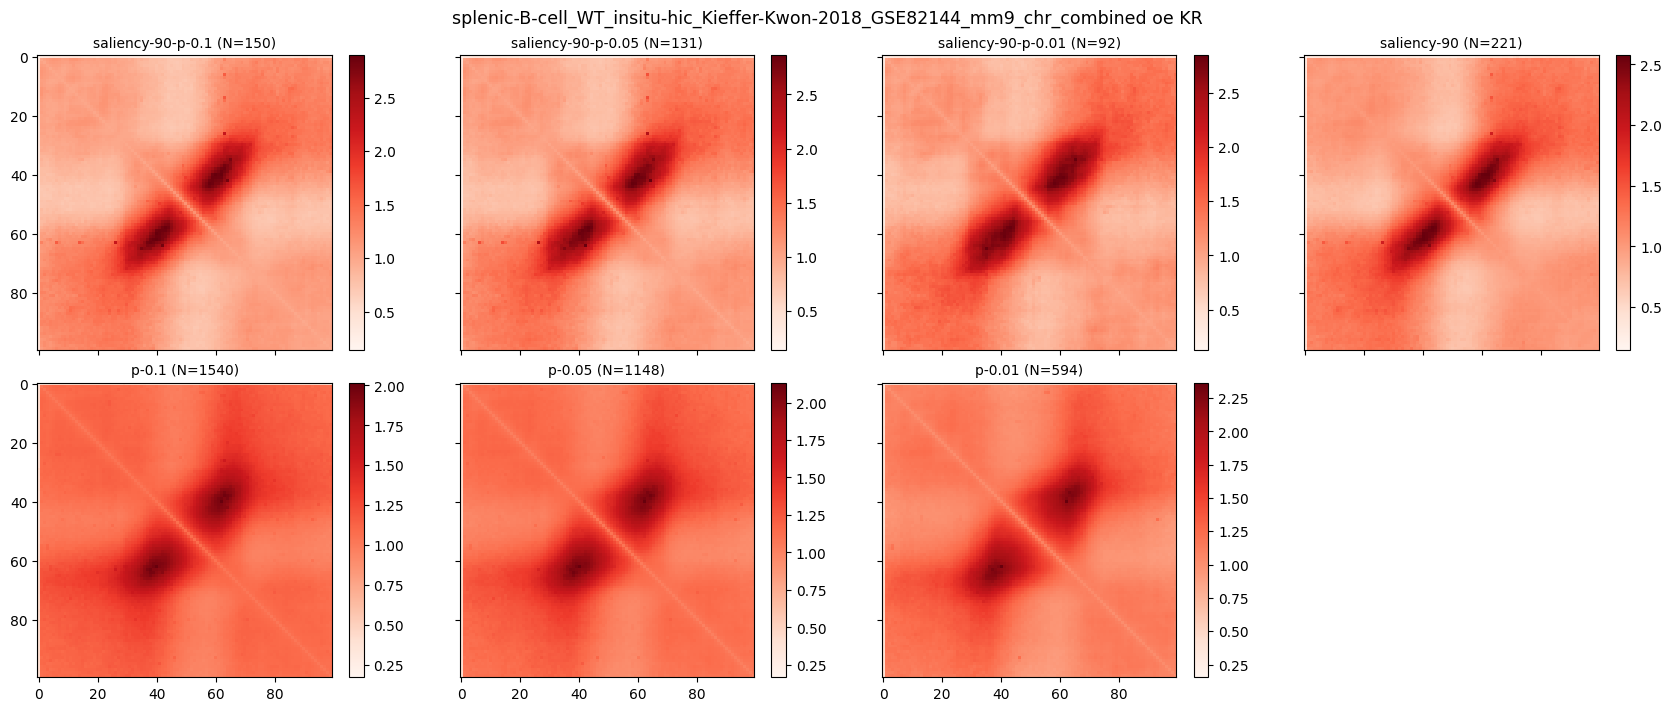

In [30]:
titles = [f"{result_type[i]} (N={stack[i].shape[0]})" for i in range(len(result_type))]
plot_n_hic(
    agg_map,
    suptitle=f"{experiment_name} {data_type} {normalization}",
    resolution=None,
    cmap_label=None,
    titles=titles,
    cmap='Reds',
    show=True, 
    ppr=4,
    savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
)

In [31]:
idx = 0
rt = result_type[idx]
rt

'saliency-90-p-0.1'

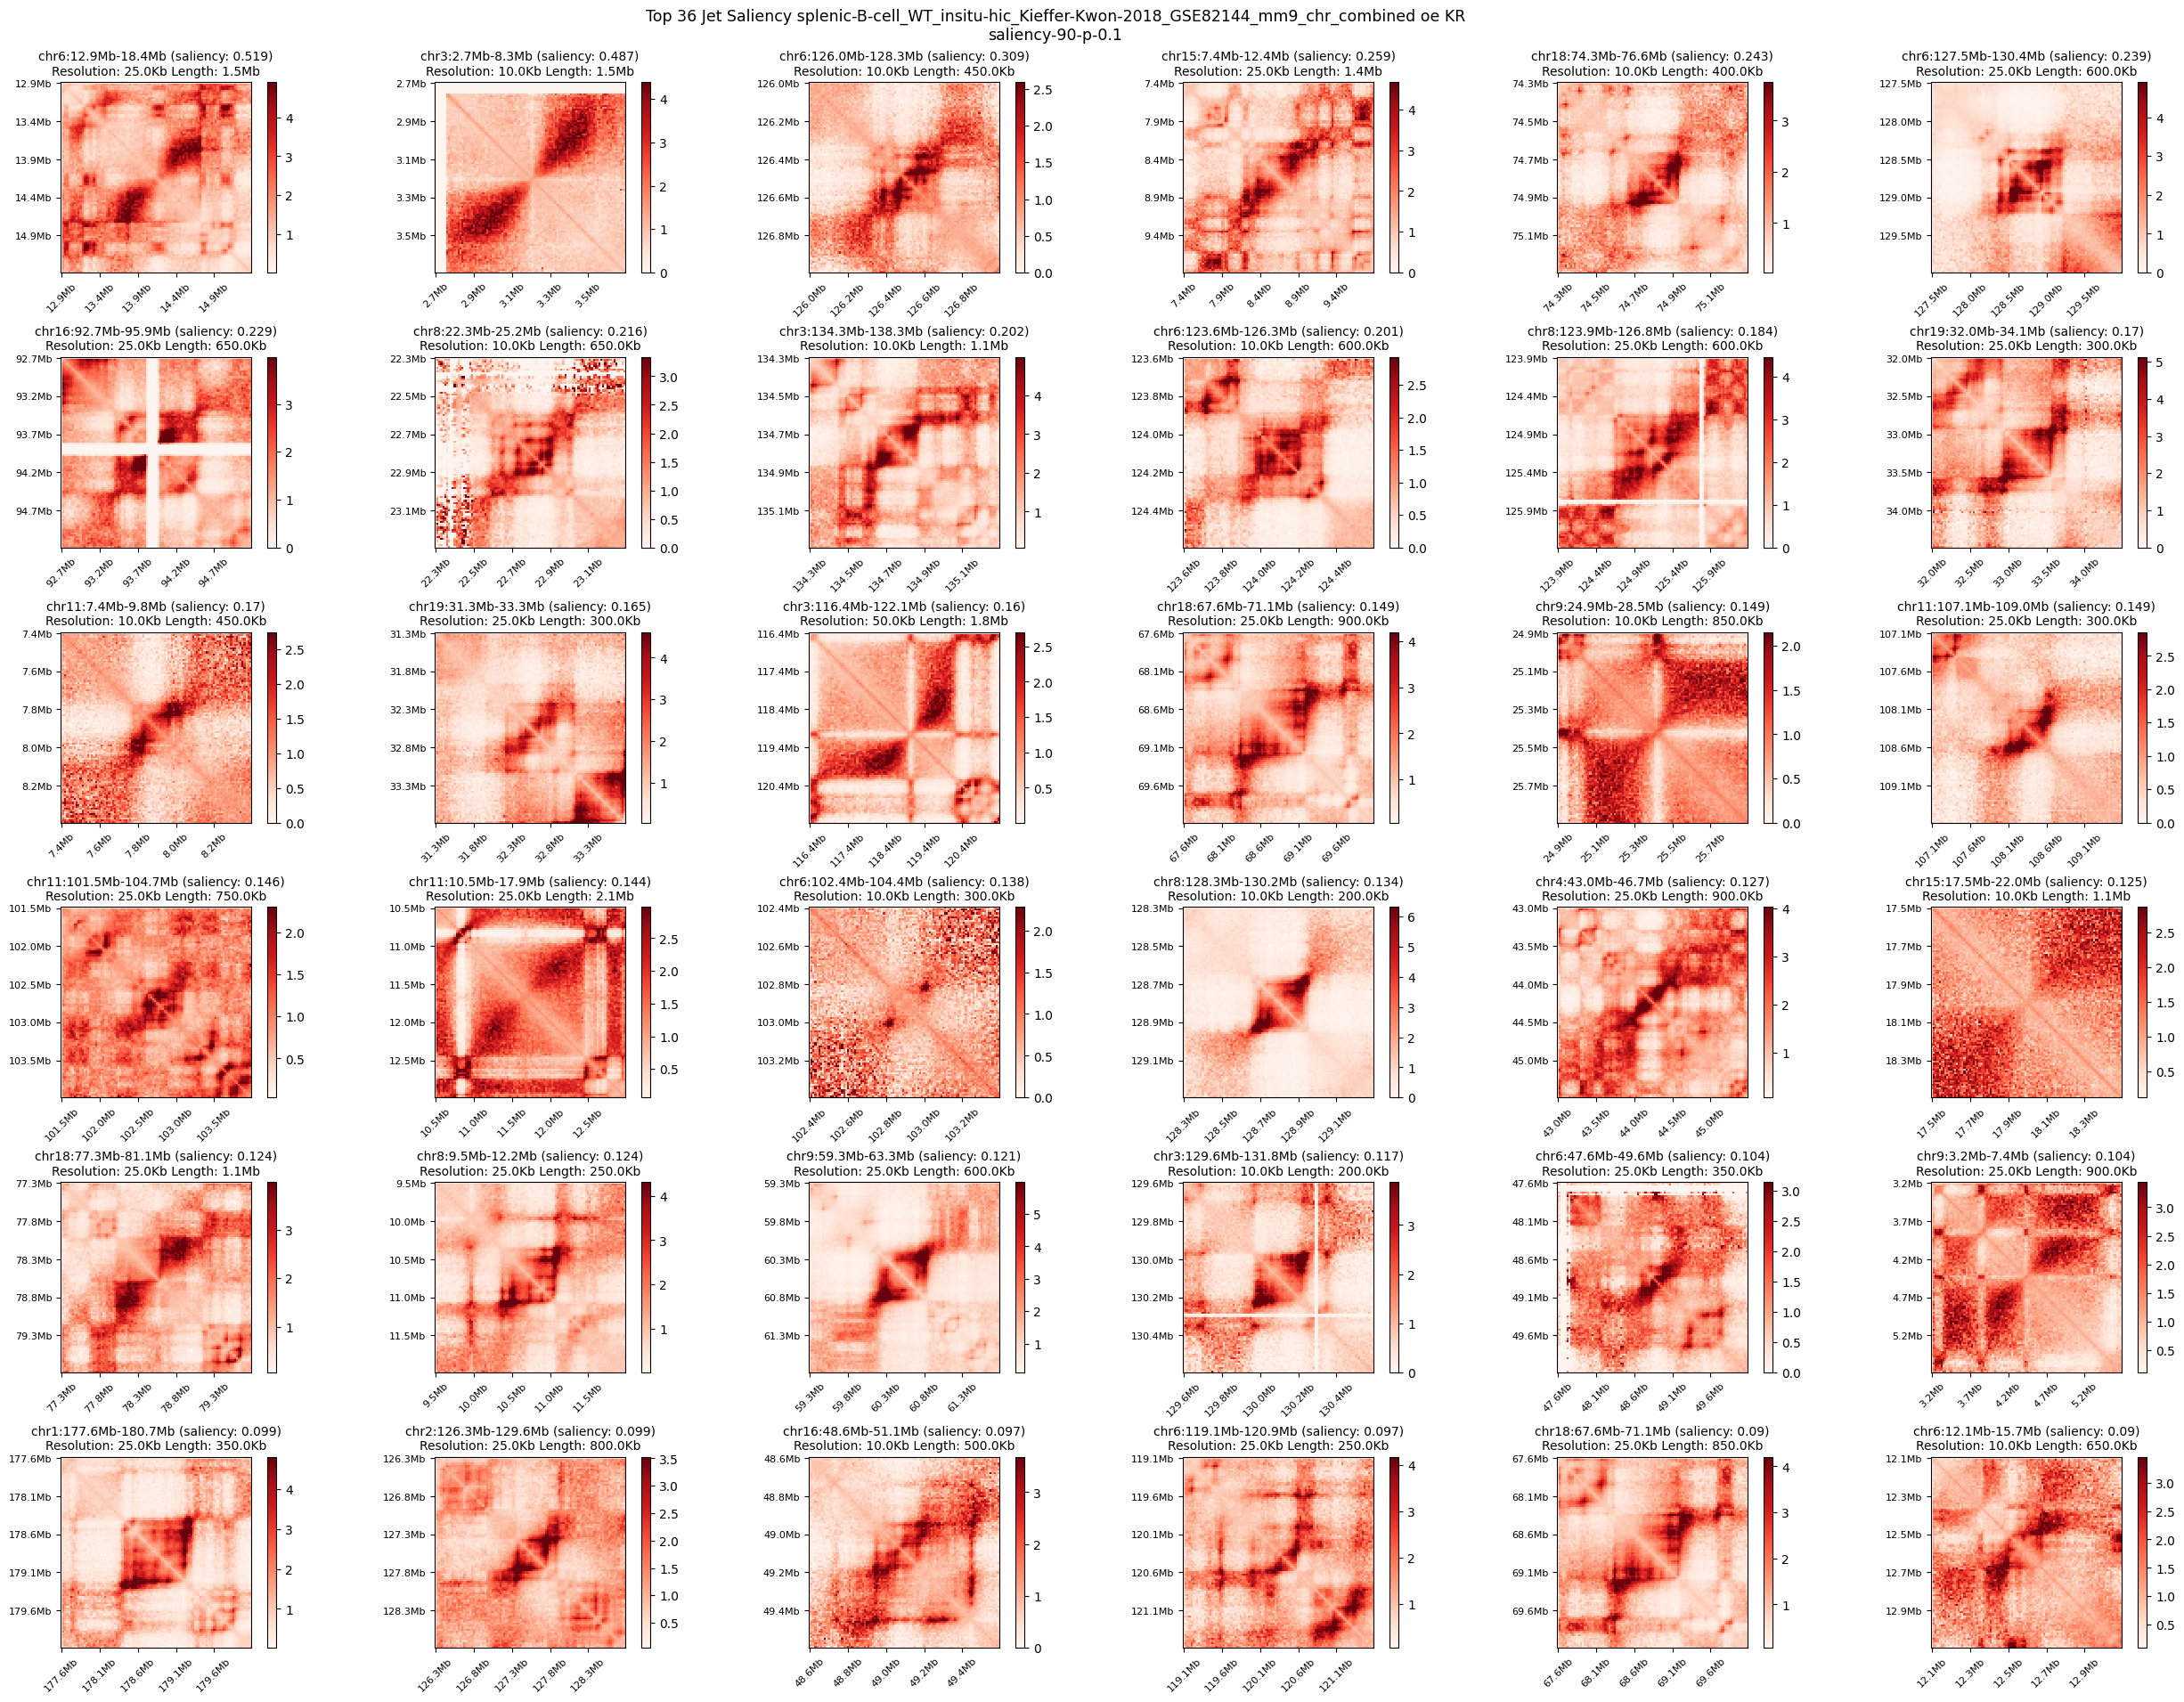

In [32]:
# Select top jets according to "jet_saliency" column
top_n = 36
# 1) get the original row‐indices of the top N
top_idx = df_stack[idx].nlargest(top_n, "jet_saliency").index

# 2) subset the DataFrame (and only then reset if you like)
sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

# 3) subset the array with those SAME indices
sampled_stack = stack[idx][top_idx]

titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions[idx]]).astype(str) + " Length: " + sampled_df_stack["length"].apply(lambda x : genomic_labels(x, N=1)).astype(str)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

vmaxes = [np.percentile(s, 99) for s in sampled_stack]

plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolutions[idx],
           suptitle=f"Top {top_n} Jet Saliency {experiment_name} {data_type} {normalization}\n{rt}", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           vmax=vmaxes,
           ppr=6,
           cmap="Reds")

## Fixed Resolution (problematic)

In [9]:
hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9.hic"
experiment_name = "splenic-B-cell_WT_insitu-hic_Kieffer-Kwon-2018_GSE82144_mm9_chr_combined"
save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
f_expanded_table = []
f_summary_table = []
for rt in result_type:
    f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
    f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
genome = "mm9"


# hic_file = "/nfs/turbo/umms-minjilab/downloaded_data/Repli-HiC_K562_WT_totalS.hic"
# experiment_name = "Repli-HiC_K562_WT_totalS_chr_combined"
# save_folder = f"/nfs/turbo/umms-minjilab/sionkim/miajet_output/{experiment_name}_50Kb"
# result_type = ["saliency-90-p-0.1", "saliency-90-p-0.05", "saliency-90-p-0.01", "saliency-90", "p-0.1", "p-0.05", "p-0.01"]
# f_expanded_table = []
# f_summary_table = []
# for rt in result_type:
#     f_expanded_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_expanded_table.csv")
#     f_summary_table.append(f"{save_folder}/{experiment_name}_{rt}_50Kb_summary_table.csv")
# genome = "hg19"


# Note that these parmameters need not be the same as the parameters used to call the jets
# This resolution is used for plotting purposes 
resolution = 50000  
data_type = "oe"
normalization = "KR"
window_size = 6e6
expected_stack_size = np.ceil(window_size / resolution + 1).astype(int)


In [10]:
# Load in tables
df_expanded = []
df_summary = []

for i in range(len(result_type)):
    df_expanded.append(pd.read_csv(f_expanded_table[i], index_col=False, comment="#"))
    df_summary.append(pd.read_csv(f_summary_table[i], index_col=False, comment="#"))

# Fetch chromosome sizes for this genome
chrom_sizes = bf.fetch_chromsizes(genome, as_bed=True)

In [11]:
for i in range(len(result_type)):
    df_summary[i] = generate_bed_df(df_summary[i], df_expanded[i], eps=0, fraction=0.5)

In [12]:
# Single core
agg_map = []
stack = []
df_stack = []
vmaxes = []

for i in range(len(result_type)):
    s, d = get_pileups(
        hic_file,
        bed_df_in=df_summary[i],
        resolution=resolution,
        chrom_sizes=chrom_sizes,
        chromosomes='all',
        window_range=(window_size // 2, window_size // 2),
        data_type=data_type,
        normalization=normalization,
        sort=False
    )

    # do processing on stack now
    s, d = remove_stack_centromeres(s, d, expected_stack_size=expected_stack_size)
    # s = np.log10(s + 1) # log transform for visualization

    agg_map.append(np.mean(s, axis=0))  # Aggregate map for this result type

    vmaxes.append(np.percentile(agg_map[-1], 99))  # per‐panel vmax

    stack.append(s)
    df_stack.append(d)

100%|██████████| 594/594 [00:19<00:00, 30.84it/s]


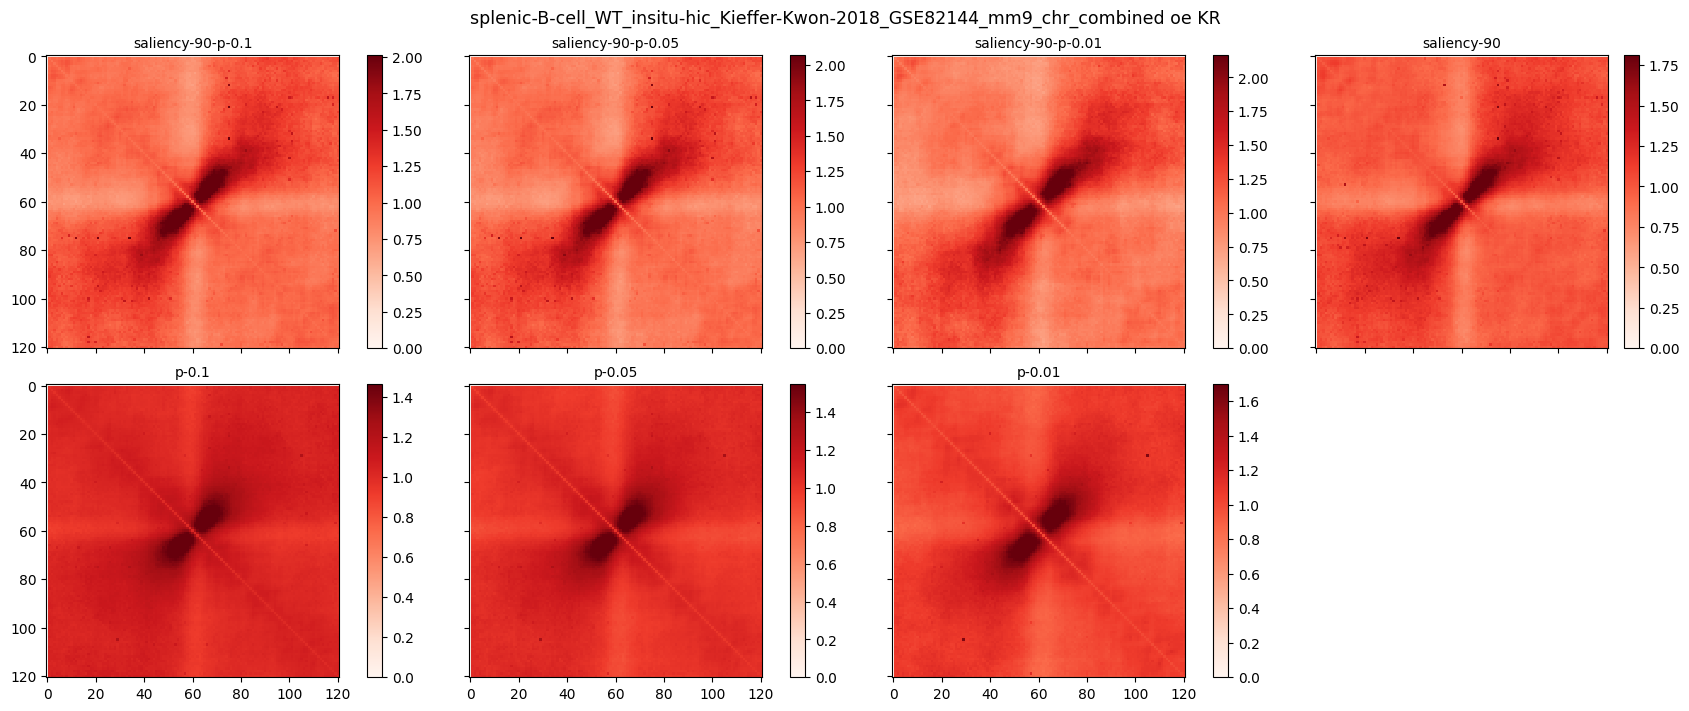

In [13]:
plot_n_hic(
    agg_map,
    suptitle=f"{experiment_name} {data_type} {normalization}",
    resolution=None,
    cmap_label=None,
    titles=result_type,
    cmap='Reds',
    show=True, 
    ppr=4,
    vmax=vmaxes,
    # savepath=f"{save_folder}/{experiment_name}_agg_map-{data_type}-{normalization}.png"
)

In [14]:
idx = 0
rt = result_type[idx]
rt

'saliency-90-p-0.1'

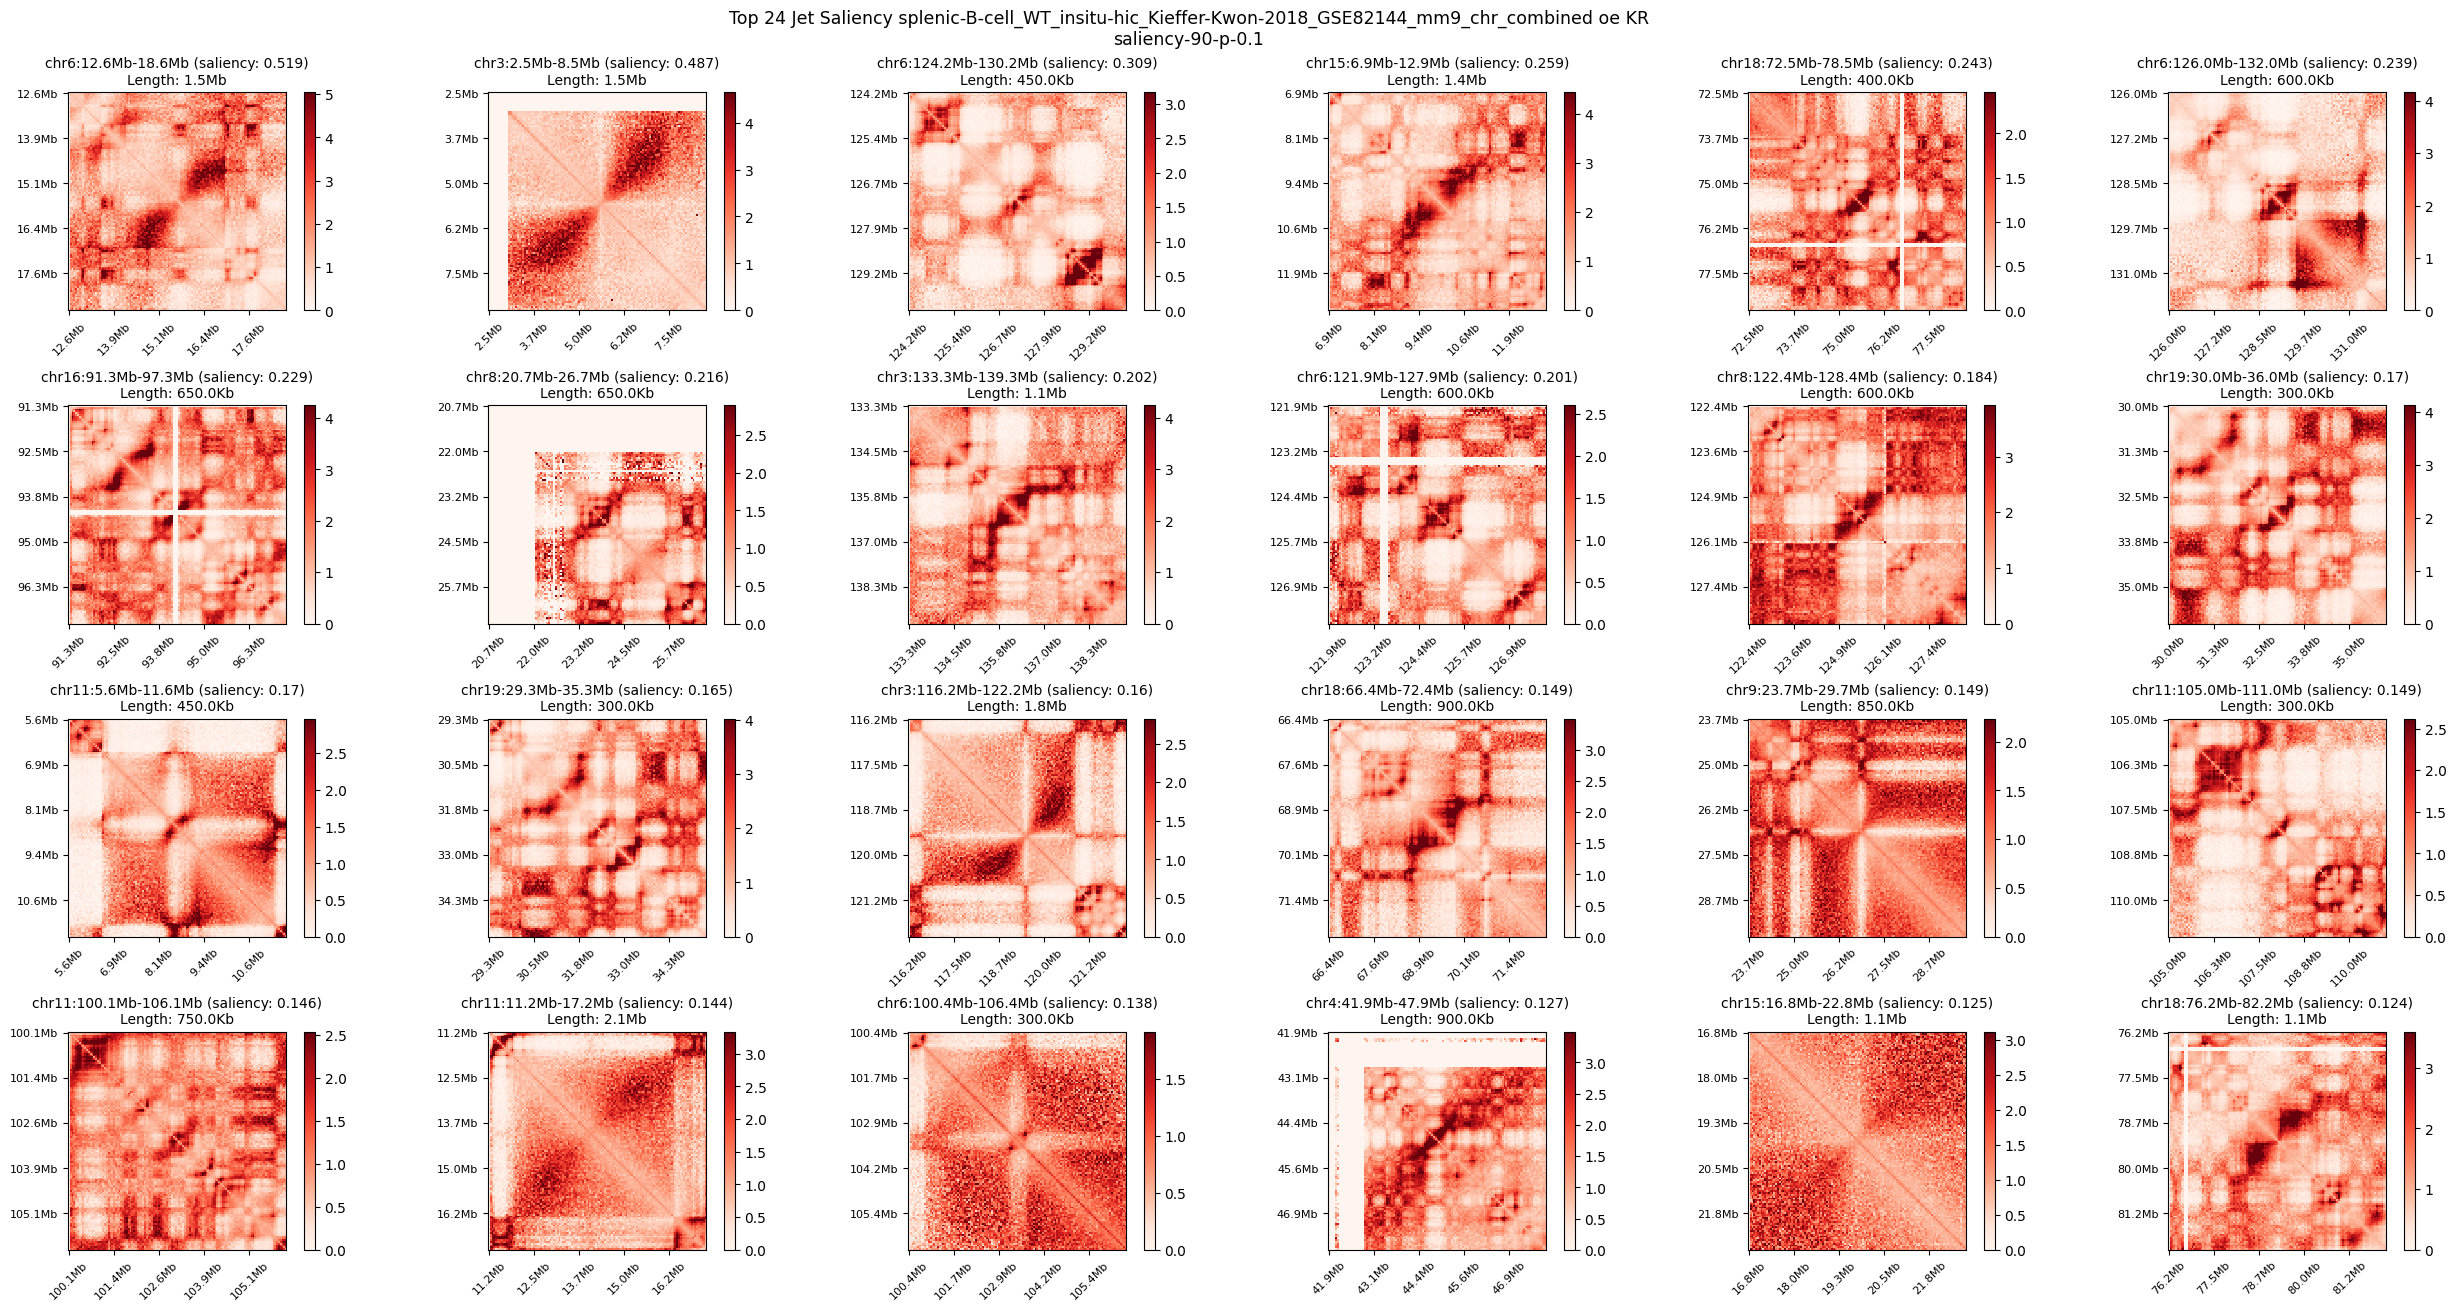

In [15]:
# Select top jets according to "jet_saliency" column
top_n = 24
# 1) get the original row‐indices of the top N
top_idx = df_stack[idx].nlargest(top_n, "jet_saliency").index

# 2) subset the DataFrame (and only then reset if you like)
sampled_df_stack = df_stack[idx].loc[top_idx].reset_index(drop=True)

# 3) subset the array with those SAME indices
sampled_stack = stack[idx][top_idx]

titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles += "\nLength: " + sampled_df_stack["length"].apply(lambda x : genomic_labels(x, N=1)).astype(str)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

vmaxes = [np.percentile(s, 99) for s in sampled_stack]

plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolution,
           suptitle=f"Top {top_n} Jet Saliency {experiment_name} {data_type} {normalization}\n{rt}", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           vmax=vmaxes,
           ppr=6,
           cmap="Reds")

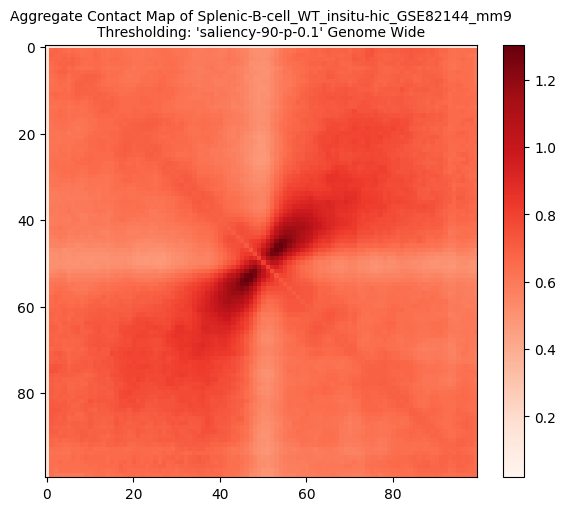

In [ ]:
plot_hic(agg_map, 
         resolution=None, # variable resolution 
         cmap="Reds",
         title="Aggregate Contact Map of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide")

In [ ]:
# Select top jets according to "jet_saliency" column
top_n = 36
# 1) get the original row‐indices of the top N
top_idx = df_stack.nlargest(top_n, "jet_saliency").index

# 2) subset the DataFrame (and only then reset if you like)
sampled_df_stack = df_stack.loc[top_idx].reset_index(drop=True)

# 3) subset the array with those SAME indices
sampled_stack = stack[top_idx]


titles = sampled_df_stack["chrom"].astype(str) + ":" + sampled_df_stack["start"].apply(lambda x : genomic_labels(x, N=1)) + "-" + sampled_df_stack["end"].apply(lambda x : genomic_labels(x, N=1))
titles += " (saliency: " + sampled_df_stack["jet_saliency"].astype(str) + ")"
titles += f"\nResolution: " + pd.Series([genomic_labels(r, N=1) for r in resolutions]).astype(str) + " Length: " + sampled_df_stack["length"].apply(lambda x : genomic_labels(x, N=1)).astype(str)
titles = titles.tolist()

genomic_shift = sampled_df_stack["start"].to_numpy()

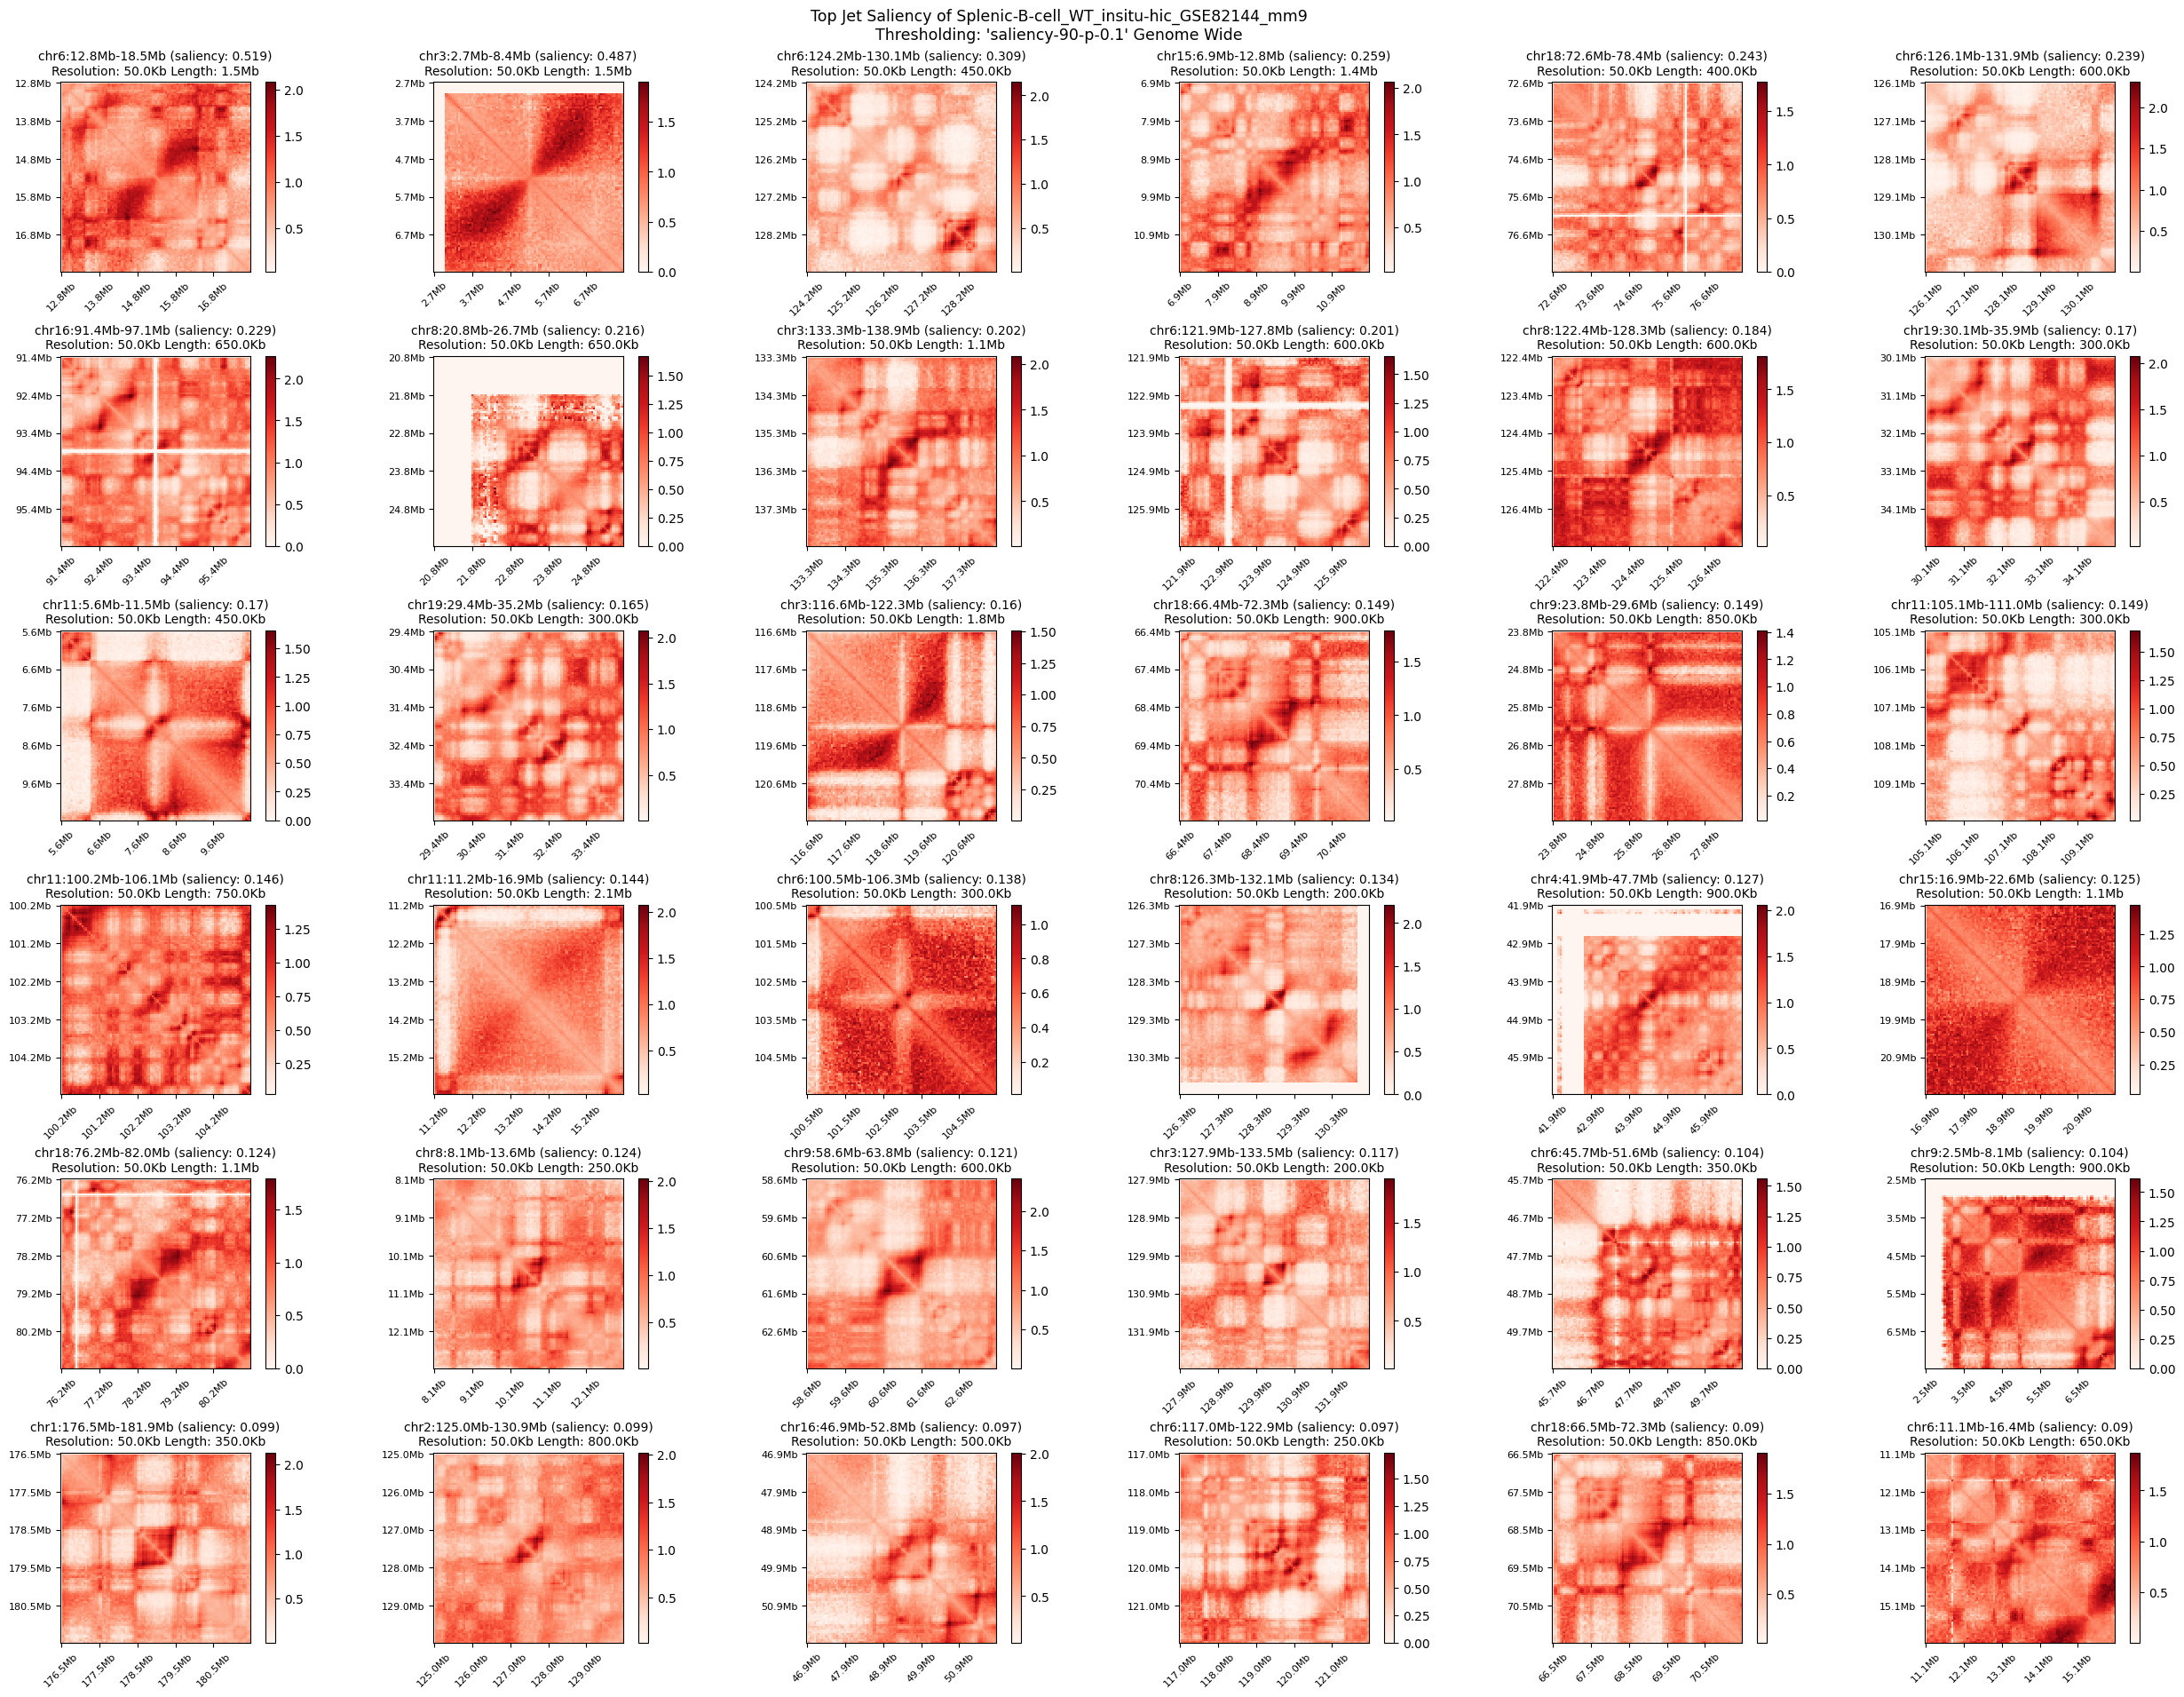

In [ ]:
plot_n_hic(sampled_stack, 
           titles=titles, 
           resolution=resolutions,
           suptitle="Top Jet Saliency of Splenic-B-cell_WT_insitu-hic_GSE82144_mm9\nThresholding: 'saliency-90-p-0.1' Genome Wide", 
           show=True, 
           genomic_shift=genomic_shift, 
           cmap_label=None, 
           ppr=6,
           cmap="Reds")